In [58]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa import stattools

In [3]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = target_df.join(predictor_df).sort_index(ascending=True)

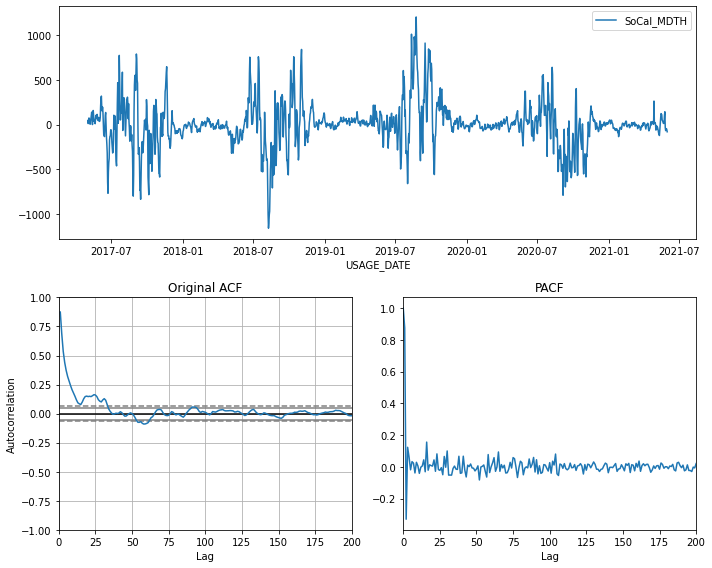

In [119]:
# identify whether target series is stationary by checking acf plot

# create a differenced series. Used for seasonal adjustment
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

def acf_plots(data):
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    sns.lineplot(data=data, ax=ax1)

    pd.plotting.autocorrelation_plot(data, ax=ax2)
    ax2.set_title('Original ACF'), ax2.set_ylim([-1, 1]), ax2.set_xlim([0, 200])

    sns.lineplot(data=stattools.pacf(data, nlags=200), ax=ax3)
    ax3.set_title('PACF'), ax3.set_xlabel('Lag'), ax3.set_xlim([0, 200])

    plt.tight_layout(), plt.show()

# acf_plots(df['SoCal_TOTAL'])
seasonal_diff = pd.DataFrame({'SoCal_MDTH': difference(df['SoCal_TOTAL'], interval=365)})
seasonal_diff.index = df.sort_index(ascending=False).index[:len(seasonal_diff)]
acf_plots(seasonal_diff)

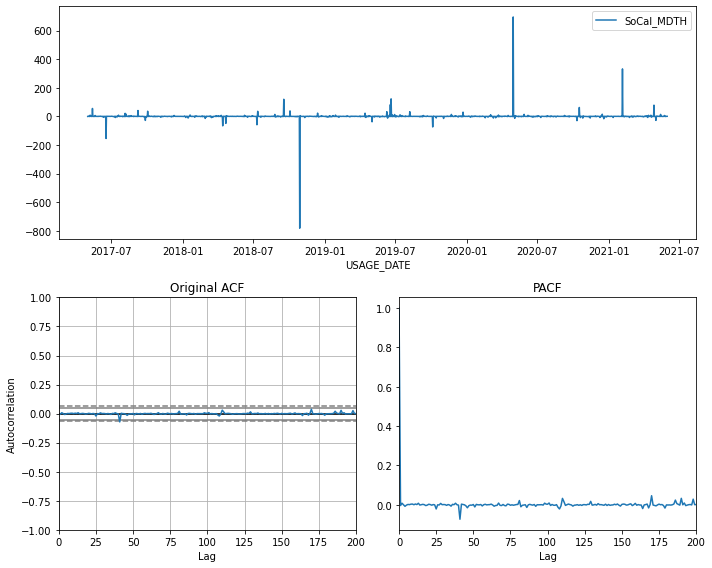

In [120]:
acf_plots(seasonal_diff.sort_index(ascending=True).pct_change().dropna())

In [95]:
acf_plots(seasonal_diff)




In [49]:
df_test = df[df.index >= pd.to_datetime('4/15/21')] 
df_train = df[df.index < pd.to_datetime('4/15/21')]
stepwise_fit = pm.auto_arima(df_train['SoCal_TOTAL'], start_p=1, max_p=5,
                             start_q=1, max_q=5, 
                             seasonal=True, m=365.25,
                            stepwise=True)
stepwise_fit.summary()

KeyboardInterrupt: 

In [ ]:
predictions = pd.DataFrame({'ARIMA_predict': stepwise_fit.predict(len(df_test))})
predictions.index=df_test.index

compare_df = pd.concat([df_test['SoCal_TOTAL'], predictions], axis=1).rename(columns={'SoCal_TOTAL': 'Test'})
sns.lineplot(data=df_train['SoCal_TOTAL'], color='k', label='Train')
sns.lineplot(data=compare_df, )
plt.xlim([df_train.index.max() - pd.DateOffset(months=1), df_test.index.max()])
plt.show()

In [ ]:
# transform target data to stationary

lb_test = sm.stats.acorr_ljungbox(df[forecast_column+'_residuals'], lags=[27])

df['SoCal_TOTAL']

In [ ]:
tmp = ARIMA(df['SoCal_TOTAL'].pct_change().dropna()).fit()
tmp.summary()

In [ ]:
def objfunc(order, exog, endog):
    fit = ARIMA(endog, order, exog).fit()
    return fit.aic()

from scipy.optimize import brute
grid = (slice(1, 3, 1), slice(1, 3, 1), slice(1, 3, 1))
brute(objfunc, grid, args=(exog, endog), finish=None)